In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

import string

In [2]:
df = pd.read_csv('steam_reviews.csv')


In [3]:
df_sorted=df.groupby(['app_id', 'app_name'])['review'].count().sort_values(ascending=False)
df_sorted = df_sorted.reset_index(name='count')
df_sorted

,app_id,app_name,count
0,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,1643246
1,271590,Grand Theft Auto V,1017315
2,359550,Tom Clancy's Rainbow Six Siege,840316
3,105600,Terraria,671774
4,4000,Garry's Mod,654511
...,...,...,...
310,611760,Don't Escape: 4 Days to Survive,1011
311,385560,Shadow Complex Remastered,700
312,619290,Out of the Park Baseball 19,700
313,574050,DRAGON QUEST HEROES™ II,600


In [4]:
df_game = pd.read_csv('steam_games.csv')

C:\Users\Jerry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
print(df_game.columns)
print(df_sorted.columns)

Index(['App ID', 'Name', 'Short Description', 'Developer', 'Publisher',
       'Genre', 'Tags', 'Type', 'Categories', 'Owners', 'Positive Reviews',
       'Negative Reviews', 'Price', 'Initial Price', 'Discount', 'CCU',
       'Languages', 'Platforms', 'Release Date', 'Required Age', 'Website',
       'Header Image'],
      dtype='object')
Index(['app_id', 'app_name', 'count'], dtype='object')


In [6]:
df_game = df_game.rename(columns={'App ID': 'app_id'})

In [7]:
df_merged = pd.merge(df_game, df_sorted, on='app_id')
# CCU Peak concurrent players as of 2022/11/8.
cols_to_show = ['app_id', 'Name', 'Genre', 'Owners','Positive Reviews','Negative Reviews','TotalReviews2022','count']
df_merged['TotalReviews2022'] = df_merged['Positive Reviews'] + df_merged['Negative Reviews']

# show only the selected columns
df_selected_cols = df_merged[cols_to_show]
df_sorted_by_owners = df_selected_cols.sort_values(by='count', ascending=False)
df_sorted_by_owners = df_sorted_by_owners.rename(columns={'count': 'TotalReviews2021'})
df_sorted_by_owners

,app_id,Name,Genre,Owners,Positive Reviews,Negative Reviews,TotalReviews2022,TotalReviews2021
97,578080,PUBG: BATTLEGROUNDS,"Action, Adventure, Free to Play, Massively Mul...","50,000,000 .. 100,000,000",1185361.0,908515.0,2093876.0,1643246
14,4000,Garry's Mod,"Indie, Simulation","20,000,000 .. 50,000,000",861240.0,29998.0,891238.0,654511
199,945360,Among Us,Casual,"20,000,000 .. 50,000,000",586302.0,52414.0,638716.0,483393
4,381210,Dead by Daylight,Action,"10,000,000 .. 20,000,000",509637.0,116397.0,626034.0,418429
19,413150,Stardew Valley,"Indie, RPG, Simulation","10,000,000 .. 20,000,000",497558.0,9283.0,506841.0,315203
...,...,...,...,...,...,...,...,...
115,611760,Don't Escape: 4 Days to Survive,"Adventure, Indie","100,000 .. 200,000",1542.0,31.0,1573.0,1011
6,385560,Shadow Complex Remastered,Action,"100,000 .. 200,000",706.0,130.0,836.0,700
119,619290,Out of the Park Baseball 19,"Indie, Simulation, Sports, Strategy","20,000 .. 50,000",630.0,108.0,738.0,700
95,574050,DRAGON QUEST HEROES II,"Action, RPG","50,000 .. 100,000",516.0,221.0,737.0,600


there is only 201 games found in the dataset

In [14]:
df_sorted_by_owners["Owners"].value_counts()

201

In [9]:
delay_mapping = {
    "0 .. 20,000": "cat1",
    "20,000 .. 50,000": "cat1",
    "50,000 .. 100,000": "cat1",
    "100,000 .. 200,000": "cat2",
    "200,000 .. 500,000": "cat2",
    "500,000 .. 1,000,000": "cat2",
    "1,000,000 .. 2,000,000": "cat3",
    "2,000,000 .. 5,000,000": "cat3",
    "5,000,000 .. 10,000,000": "cat3",
    "10,000,000 .. 20,000,000": "cat4",
    "20,000,000 .. 50,000,000": "cat4",
    "50,000,000 .. 100,000,000": "cat4",
    "200,000,000 .. 500,000,000": "cat4",   
}

In [10]:
df_sorted_by_owners["CAT"] = df_sorted_by_owners["Owners"].map(delay_mapping)

In [16]:
df_sorted_by_owners.Genre.value_counts()

Action                                   30
RPG                                      10
Action, Adventure                         9
Action, RPG                               9
Adventure                                 7
                                         ..
Action, Free to Play                      1
Action, Massively Multiplayer, Racing     1
Action, Indie, Strategy                   1
Massively Multiplayer, RPG                1
Indie, RPG                                1
Name: Genre, Length: 80, dtype: int64

In [18]:
tops=df_sorted_by_owners.Genre.value_counts().head(10).index
tops
ds= df_sorted_by_owners[df_sorted_by_owners.Genre.isin(tops)]
ds

,app_id,Name,Genre,Owners,Positive Reviews,Negative Reviews,TotalReviews2022,TotalReviews2021,CAT
14,4000,Garry's Mod,"Indie, Simulation","20,000,000 .. 50,000,000",861240.0,29998.0,891238.0,654511,cat4
4,381210,Dead by Daylight,Action,"10,000,000 .. 20,000,000",509637.0,116397.0,626034.0,418429,cat4
161,72850,The Elder Scrolls V: Skyrim,RPG,"5,000,000 .. 10,000,000",295128.0,16066.0,311194.0,294507,cat3
99,582010,Monster Hunter: World,Action,"10,000,000 .. 20,000,000",313338.0,52130.0,365468.0,290532,cat4
0,374320,DARK SOULS III,Action,"5,000,000 .. 10,000,000",317233.0,20332.0,337565.0,235203,cat3
...,...,...,...,...,...,...,...,...,...
15,400940,Budget Cuts,"Action, Adventure, Indie","200,000 .. 500,000",1320.0,324.0,1644.0,1296,cat2
85,551730,Toukiden 2,Action,"50,000 .. 100,000",1054.0,271.0,1325.0,1200,cat1
6,385560,Shadow Complex Remastered,Action,"100,000 .. 200,000",706.0,130.0,836.0,700,cat2
95,574050,DRAGON QUEST HEROES II,"Action, RPG","50,000 .. 100,000",516.0,221.0,737.0,600,cat1


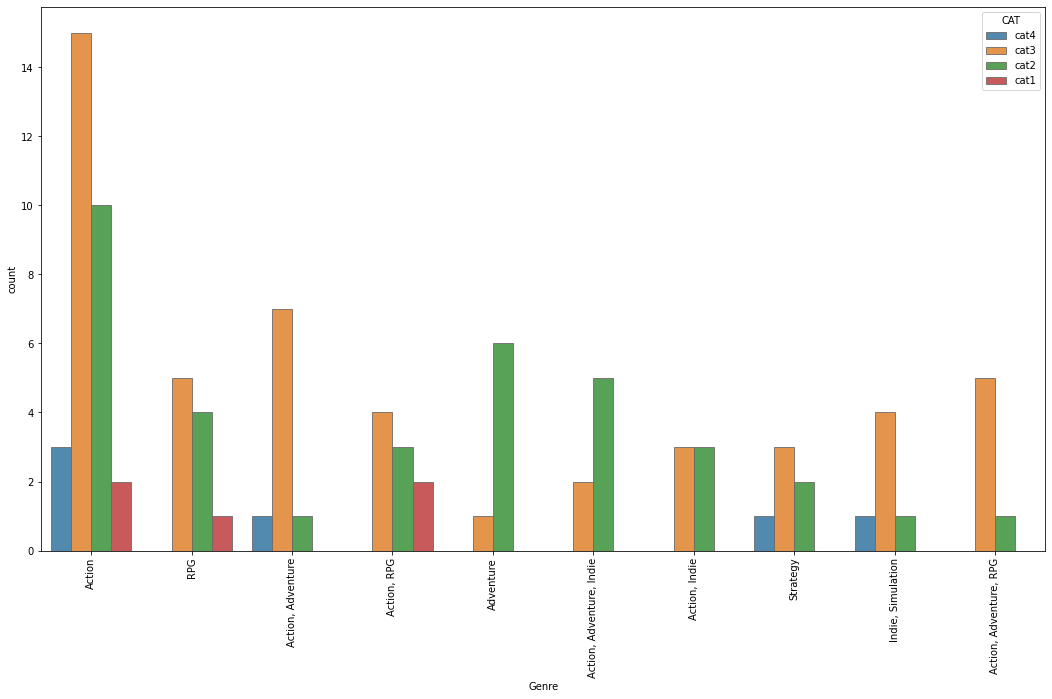

In [24]:
# Owners count in owners' groups
import seaborn as sns
color_pal=plt.rcParams["axes.prop_cycle"].by_key()["color"]
black_grad = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']

plt.figure(figsize=(18, 10))
sns.countplot(x = "Genre", data = ds, palette = color_pal, edgecolor = black_grad[2], alpha = 0.85, hue="CAT", order=tops)
plt.xticks(rotation=90)
plt.show()

In [28]:
df_sorted_by_owners

,app_id,Name,Genre,Owners,Positive Reviews,Negative Reviews,TotalReviews2022,TotalReviews2021,CAT
97,578080,PUBG: BATTLEGROUNDS,"Action, Adventure, Free to Play, Massively Mul...","50,000,000 .. 100,000,000",1185361.0,908515.0,2093876.0,1643246,cat4
14,4000,Garry's Mod,"Indie, Simulation","20,000,000 .. 50,000,000",861240.0,29998.0,891238.0,654511,cat4
199,945360,Among Us,Casual,"20,000,000 .. 50,000,000",586302.0,52414.0,638716.0,483393,cat4
4,381210,Dead by Daylight,Action,"10,000,000 .. 20,000,000",509637.0,116397.0,626034.0,418429,cat4
19,413150,Stardew Valley,"Indie, RPG, Simulation","10,000,000 .. 20,000,000",497558.0,9283.0,506841.0,315203,cat4
...,...,...,...,...,...,...,...,...,...
115,611760,Don't Escape: 4 Days to Survive,"Adventure, Indie","100,000 .. 200,000",1542.0,31.0,1573.0,1011,cat2
6,385560,Shadow Complex Remastered,Action,"100,000 .. 200,000",706.0,130.0,836.0,700,cat2
119,619290,Out of the Park Baseball 19,"Indie, Simulation, Sports, Strategy","20,000 .. 50,000",630.0,108.0,738.0,700,cat1
95,574050,DRAGON QUEST HEROES II,"Action, RPG","50,000 .. 100,000",516.0,221.0,737.0,600,cat1


In [42]:
# Calculate the positive review rate
df_sorted_by_owners['PositiveReviewRate'] = df_sorted_by_owners['Positive Reviews'] / (df_sorted_by_owners['TotalReviews2022'])

# Sort the dataframe by positive review rate in descending order and select the top row
top_rated_game = df_sorted_by_owners.sort_values(by='PositiveReviewRate', ascending=False).head(20)

# Print the name of the top rated game
print(top_rated_game['Name'])


120                                    Portal 2
83                              Half-Life: Alyx
26                                      OneShot
19                               Stardew Valley
166                                 Baba Is You
35                             Wallpaper Engine
115             Don't Escape: 4 Days to Survive
137                              Slay the Spire
63            Totally Accurate Battle Simulator
36                                Slime Rancher
69                                         DUSK
29                                 The Room Two
62                                      Celeste
75                          Just Shapes & Beats
53                       Mount & Blade: Warband
179        Phoenix Wright: Ace Attorney Trilogy
41     VA-11 Hall-A: Cyberpunk Bartender Action
18                                  STEINS;GATE
200                                 Bloons TD 6
72                                 Satisfactory
Name: Name, dtype: object


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Sort the dataframe by positive review rate in descending order
df_sorted = df_sorted_by_owners.sort_values(by='PositiveReviewRate', ascending=False)

# Plot a horizontal bar chart
ax.barh(df_sorted['Name'], df_sorted['PositiveReviewRate'], color='green')

# Set the title and labels for the chart
ax.set_title('Top Rated Games by Positive Review Rate')
ax.set_xlabel('Positive Review Rate')
ax.set_ylabel('Game Name')

# Show the chart
plt.show()